In [21]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from tensorflow.keras.utils import to_categorical

In [22]:
# Read the CSV file
df = pd.read_csv('data/preprocessed_data.csv')

# Convert the DataFrame to a numpy array
input_sequences = df.values

# Extract X and y
X, y = input_sequences[:, :-1], input_sequences[:, -1]


In [23]:
X

array([[   0,    0,    0, ...,    0,    0,    1],
       [   0,    0,    0, ...,    0,    1,  687],
       [   0,    0,    0, ...,    1,  687,    4],
       ...,
       [   0,    0,    0, ...,  687,    4,   45],
       [   0,    0,    0, ...,    4,   45, 1047],
       [   0,    0,    0, ...,   45, 1047,    4]])

In [24]:
y

array([ 687,    4,   45, ..., 1047,    4,  193])

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
(pd.DataFrame(X_train).shape, pd.DataFrame(X_test).shape)

((20585, 13), (5147, 13))

In [27]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,78,8,22,81,686,28
1,0,0,0,0,0,0,0,0,0,0,0,1806,289
2,0,0,0,0,0,0,0,0,5,4482,42,1381,29
3,0,0,0,0,0,0,0,0,0,0,0,74,550
4,0,0,0,0,0,0,0,0,0,0,0,555,1102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20580,0,0,0,0,0,0,0,0,0,0,0,0,83
20581,0,0,0,0,0,0,20,18,466,3,65,24,13
20582,0,0,0,0,0,0,0,0,0,0,0,346,71
20583,0,0,0,0,0,0,0,0,0,0,0,74,45


In [28]:
y_train

array([ 51,   4, 456, ..., 107,  42, 645])

In [29]:
pd.DataFrame(X_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0,0,0,0,0,0,0,0,807,2,115,49,50
1,0,0,0,0,0,0,0,0,0,0,0,26,23
2,0,0,0,0,0,0,0,39,5,3,945,212,7
3,0,0,0,0,0,0,0,0,0,0,0,30,125
4,0,0,0,0,0,0,0,0,25,70,1907,33,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5142,0,0,0,0,0,0,0,138,32,166,10,1,396
5143,0,0,0,0,0,0,42,3700,3,26,90,3701,13
5144,0,0,0,0,0,0,0,0,0,0,0,17,103
5145,0,0,0,0,0,0,0,0,0,0,0,30,379


In [30]:
y_test

array([  49,   33, 1283, ..., 2035,  343,    6])

In [31]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [32]:
# Load the pickled object
with open('artifacts/tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [33]:
total_words=len(tokenizer.word_index)+1
max_sequence_len = max([len(x) for x in input_sequences])

In [34]:
print(f"Total words (vocabulary size): {total_words}")
print(f"Max sequence length: {max_sequence_len}")
print(f"Shape of X: {X.shape}")

Total words (vocabulary size): 4818
Max sequence length: 14
Shape of X: (25732, 13)


# Train our LSTM-GRU RNN Model

In [35]:
# Define the model
model = Sequential()

# Embedding layer
# input_dim = total_words (size of the vocabulary)
# output_dim = 100 (embedding vector size, can be tuned)
# input_length = max_sequence_len-1 (length of the input sequences after removing the last token for y)
model.add(Embedding(input_dim=total_words, output_dim=100, input_length=max_sequence_len-1))

# build the Embedding to initialize the weight
#model.build((None, max_sequence_len)) 

# LSTM layer
# units = 150 (number of hidden units, can be tuned)
# return_sequences = True to stack another RNN layer on top
model.add(GRU(units=150, return_sequences=True))
model.add(Dropout(rate=0.2))  # Dropout for regularization

# GRU layer
# units = 100 (number of hidden units)
# return_sequences = False since this is the last RNN layer
model.add(GRU(units=100))

# Dense output layer
# units = total_words (to predict one of the vocabulary words)
# activation = "softmax" for multi-class classification
model.add(Dense(units=total_words, activation="softmax"))

# Compile the model
# loss = "categorical_crossentropy" since it’s a multi-class classification problem
# optimizer = "adam" (adaptive learning rate, generally effective for RNNs)
# metrics = ['accuracy'] to track performance during training
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Display model summary
model.summary()



/Users/mansysoroush/Documents/Others/Learnings/GitHub Projects/DataAnalysis_MachineLearning_Python_Projects/NextWordPrediction_DL_RNN_LSTM_GRU/venv/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=total_words)
y_test = to_categorical(y_test, num_classes=total_words)

In [37]:
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (20585, 13), y_train shape: (20585, 4818)
X_test shape: (5147, 13), y_test shape: (5147, 4818)


In [39]:
# Train the model
history = model.fit(X_train, y_train, epochs= 100, validation_data= (X_test, y_test), verbose=1)


Epoch 1/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0738 - loss: 5.8026 - val_accuracy: 0.0688 - val_loss: 6.8660
Epoch 2/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.0904 - loss: 5.5193 - val_accuracy: 0.0750 - val_loss: 6.9545
Epoch 3/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 16s 24ms/step - accuracy: 0.0990 - loss: 5.2763 - val_accuracy: 0.0705 - val_loss: 7.0345
Epoch 4/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1133 - loss: 5.0042 - val_accuracy: 0.0715 - val_loss: 7.1185
Epoch 5/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.1272 - loss: 4.7553 - val_accuracy: 0.0717 - val_loss: 7.2140
Epoch 6/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.1520 - loss: 4.5041 - val_accuracy: 0.0729 - val_loss: 7.4027
Epoch 7/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.1745 - loss: 4.2770 - val_accuracy: 0.0723 - val_loss: 7.4560
Epoch 8/100
644/644 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.2022 - loss: 4

In [40]:
model.save("artifacts/model.keras")

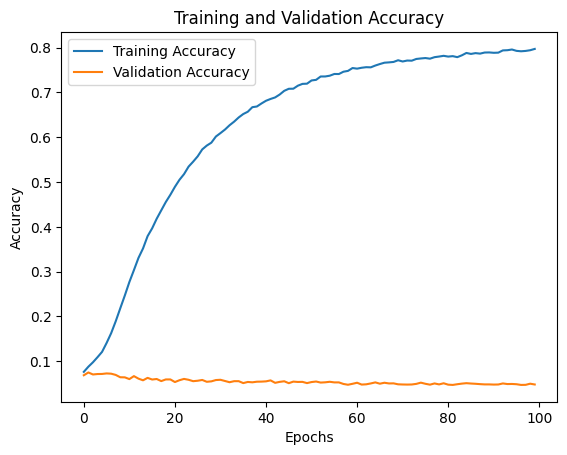

In [41]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

# Retrieve accuracy and validation accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot accuracy
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [42]:
# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0479 - loss: 12.0467
Test Loss: 12.060997009277344
Test Accuracy: 0.04818340763449669


In [45]:
import numpy as np

# Get predictions for the test dataset
y_pred = model.predict(X_test)

# Convert predictions and true labels back to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Calculate accuracy
custom_accuracy = np.mean(y_pred_classes == y_true_classes)
print(f"Custom Test Accuracy: {custom_accuracy}")

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"Test Accuracy: {accuracy}")


161/161 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Custom Test Accuracy: 0.04818340781037497
Test Accuracy: 0.04818340781037497
